# Masking and reducing datacubes using geometry objects

In [1]:
# If first time running, uncomment the line below to install any additional dependancies
# !bash requirements-for-notebooks.sh

In [2]:
import matplotlib.pyplot as plt

from earthkit import climate as ek_climate
from earthkit import data as ek_data

from earthkit.data.testing import earthkit_remote_test_data_file

# Load some test data

All `earthkit-climate` methods can be called with `earthkit-data` objects (Readers and Wrappers) or with the 
pre-loaded `xarray` or `geopandas` objects.

In this example we will use hourly ERA5 2m temperature data on a 0.5x0.5 spatial grid for the year 2015 as
our physical data; and we will use the NUTS geometries which are stored in a geojson file.

First we lazily load the ERA5 data  and NUTS geometries from our test-data repository.

Note the data is only downloaded when
we use it, e.g. at the `.to_xarray` line, additionally, the download is cached so the next time you run this
cell you will not need to re-download the file (unless it has been a very long time since you have run the
code, please see tutorials in `earthkit-data` for more details in cache management).

In [3]:
# Get some demonstration ERA5 data, this could be any url or path to an ERA5 grib or netCDF file.
remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_2015.grib")
era5_data = ek_data.from_source("url", remote_era5_file)
era5_data.to_xarray()

<xarray.Dataset>
Dimensions:     (number: 1, time: 1460, step: 1, surface: 1, latitude: 201,
                 longitude: 281)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-08-30T17:38 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
# Use some demonstration polygons stored, this could be any url or path to geojson file
remote_nuts_url = earthkit_remote_test_data_file("test-data", "NUTS_RG_60M_2021_4326_LEVL_0.geojson")
nuts_data = ek_data.from_source("url", remote_nuts_url)

nuts_data.to_pandas()[:5]

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.16290 55.09370, 15.09400 54..."
1,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.47920 45.19300, 21.35850 44.82160..."
2,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.35700 58.78710, 27.64490 57..."
3,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.07770 36.11820, 27.86060 35..."
4,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.39100 39.86170, 4.19070 39.7..."


## Mask dataarray with geodataframe

`shapes.mask` applies all the features in the geometry object (`nuts_data`) to the data object (`era5_data`).
It returns an xarray object the same shape and type as the input xarray object with all points outside of
the geometry masked

In [5]:
single_masked_data = ek_climate.shapes.mask(era5_data, nuts_data)
single_masked_data

<xarray.Dataset>
Dimensions:     (number: 1, time: 1460, step: 1, surface: 1, latitude: 201,
                 longitude: 281)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 na...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-08-30T17:38 GRIB to CDM+CF via cfgrib-0.9.1...

Text(0.5, 1.0, 'Masked data')

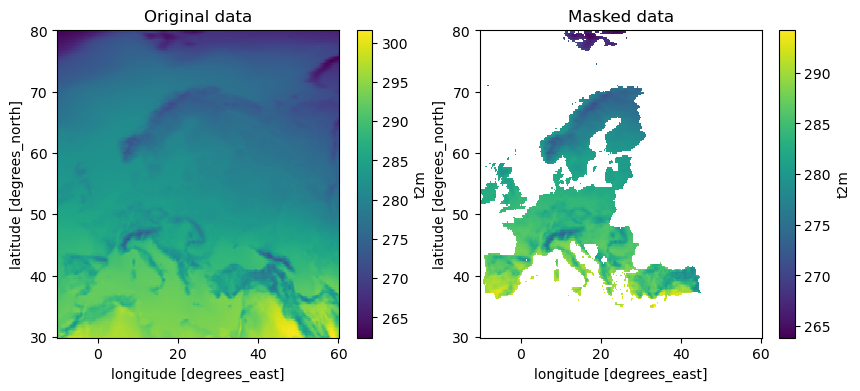

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
era5_data.to_xarray().t2m.mean(dim='time').plot(ax=axes[0])
axes[0].set_title('Original data')
# Single masked data
single_masked_data.t2m.mean(dim='time').plot(ax=axes[1])
axes[1].set_title('Masked data')

`shapes.masks` applies the features in the geometry object (`nuts_data`) to the data object (`era5_data`).
It returns an xarray object with an additional dimension, and coordinate variable, corresponding to the 
features in the geometry object.
By default this is the index of the input geodataframe, in this example the index is just an integer
count so it takes the default name `index`.

In [7]:
masked_data = ek_climate.shapes.masks(era5_data, nuts_data)
masked_data

<xarray.Dataset>
Dimensions:     (index: 37, number: 1, time: 1460, step: 1, surface: 1,
                 latitude: 201, longitude: 281)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * index       (index) int64 0 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
Data variables:
    t2m         (index, number, time, step, surface, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-08-30T17:38 GRIB to CDM+CF via cfgrib-0.9.1...

It is possible to specify a column in the geodataframe to use for the new dimension, for example in NUTS the
`FID` (= feature id) which contains the two letter identier code for each feature:

In [8]:
masked_data = ek_climate.shapes.masks(era5_data, nuts_data, mask_dim="FID")
masked_data

<xarray.Dataset>
Dimensions:     (FID: 37, number: 1, time: 1460, step: 1, surface: 1,
                 latitude: 201, longitude: 281)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * FID         (FID) object 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CY' 'CZ' 'DE' 'NO'
Data variables:
    t2m         (FID, number, time, step, surface, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-08-30T17:38 GRIB to CDM+CF via cfgrib-0.9.1...

Here we demonstrate what we have done by plotting the masked objects we have produced

Text(0.5, 1.0, 'Masked Germany Zoom')

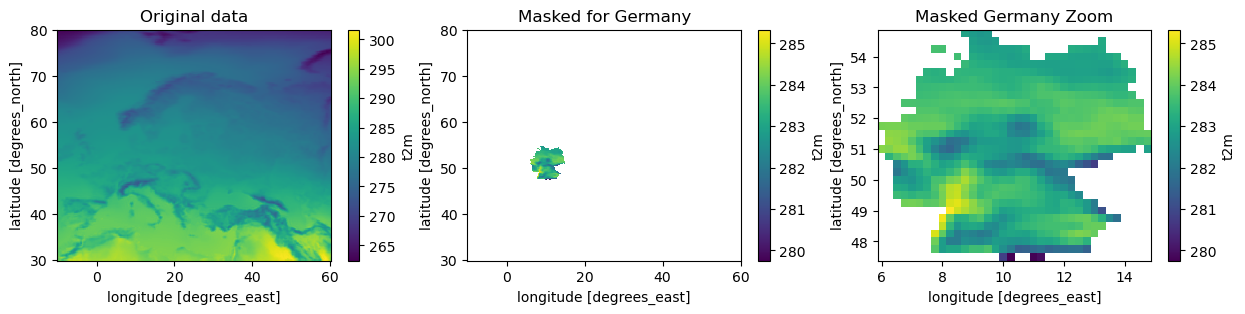

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15,3))
era5_data.to_xarray().t2m.mean(dim='time').plot(ax=axes[0])
axes[0].set_title('Original data')
masked_data.t2m.sel(FID='DE').mean(dim='time').plot(ax=axes[1])
axes[1].set_title('Masked for Germany')
germany_data = masked_data.sel(FID='DE').dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')
germany_data.t2m.mean(dim='time').plot(ax=axes[2])
axes[2].set_title('Masked Germany Zoom')

## Reduce data
### Default behaviour

The default behaviour is to reduce the data along the spatial dimensions, only, and return the reduced data
in the Xarray format it was provided, i.e. `xr.DataArray` or `xr.Dataset`.

The returned object has a new dimension `FID` (feature id) which has a coordinate variable with the values
of the `FID` column in the input `geodataframe`.

The new variable name is made up of the original variable name and the method used to reduce, e.g. `t2m_mean`

In [10]:
reduced_data = ek_climate.shapes.reduce(era5_data, nuts_data)
reduced_data

<xarray.Dataset>
Dimensions:     (time: 1460, index: 37)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    valid_time  (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * index       (index) int64 0 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
Data variables:
    t2m_mean    (index, time) float32 278.7 279.8 279.8 ... 274.4 274.2 273.8
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-08-30T17:39 GRIB to CDM+CF via cfgrib-0.9.1...

### Reduce along additional dimension

For example, any time dimension, this is advisable as it ensures correct handling missing values and weights.

The extra_reduce_dims argument takes a single string or a list of strings corresponding to dimensions to
include in the reduction.

It is also possible to select a column in the geodataframe to use to populate the dimension and coordinate 
variable created by the reduction using the `mask_dim` kwarg, here we choose the `"FID"` column.

In [11]:
reduced_data = ek_climate.shapes.reduce(era5_data, nuts_data, mask_dim="FID", extra_reduce_dims='time', all_touched=True)
reduced_data

<xarray.Dataset>
Dimensions:   (FID: 37)
Coordinates:
    number    int64 0
    step      timedelta64[ns] 00:00:00
    surface   float64 0.0
  * FID       (FID) object 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CH' 'CY' 'CZ' 'DE' 'NO'
Data variables:
    t2m_mean  (FID) float32 282.5 285.0 280.6 288.2 ... 292.9 282.9 283.3 273.8
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-08-30T17:39 GRIB to CDM+CF via cfgrib-0.9.1...

### Weighted reduction

Provide numpy/xarray arrays of weights, or use predefined weights options, i.e. `latitude`:

In [12]:
reduced_data_xr = ek_climate.shapes.reduce(era5_data, nuts_data, weights='latitude', mask_dim="FID", extra_reduce_dims='time', all_touched=True)
reduced_data_xr

<xarray.Dataset>
Dimensions:   (FID: 37)
Coordinates:
    number    int64 0
    step      timedelta64[ns] 00:00:00
    surface   float64 0.0
  * FID       (FID) object 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CH' 'CY' 'CZ' 'DE' 'NO'
Data variables:
    t2m_mean  (FID) float64 282.5 285.0 280.6 288.2 ... 292.9 282.9 283.3 275.2
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-08-30T17:39 GRIB to CDM+CF via cfgrib-0.9.1...

## Return as a pandas dataframe

**WARNING: Returning reduced data in pandas format is considered experimental and may change in futureversions of earthkit-climate** 

It is possible to return the reduced data in a fully expanded geopandas dataframe which contains the geometry 
and aggregated data.
Additional columns for the data values and rows and indexes added to fully describe the reduced data.

The returned object fully supports pandas indexing and in-built convenience methods (e.g. plotting),
but it comes with memory usage cost, hence in this example we reduce along all dimensions.

In [13]:
reduced_data_pd = ek_climate.shapes.reduce(era5_data, nuts_data, return_as="pandas", mask_dim="FID", extra_reduce_dims="time")
reduced_data_pd[:10]

Returning reduced data in pandas format is considered experimental and may change in futureversions of earthkit-climate


,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,number,step,surface,t2m_mean
FID,,,,,,,,,,,,,,,
DK,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.16290 55.09370, 15.09400 54...",0,0 days,0.0,282.484436
RS,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.47920 45.19300, 21.35850 44.82160...",0,0 days,0.0,285.003174
EE,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.35700 58.78710, 27.64490 57...",0,0 days,0.0,280.563019
EL,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.07770 36.11820, 27.86060 35...",0,0 days,0.0,288.214691
ES,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.39100 39.86170, 4.19070 39.7...",0,0 days,0.0,287.798492
FI,FI,FI,0,FI,Suomi/Finland,Suomi/Finland,0,0,0,FI,"MULTIPOLYGON (((28.89670 69.04260, 28.47820 68...",0,0 days,0.0,277.203064
FR,FR,FR,0,FR,France,France,0,0,0,FR,"MULTIPOLYGON (((55.84980 -21.18580, 55.78580 -...",0,0 days,0.0,285.117157
HR,HR,HR,0,HR,Hrvatska,Hrvatska,0,0,0,HR,"MULTIPOLYGON (((17.65150 45.84780, 17.91210 45...",0,0 days,0.0,285.965149
HU,HU,HU,0,HU,Magyarország,Magyarország,0,0,0,HU,"POLYGON ((22.12110 48.37830, 22.15530 48.40340...",0,0 days,0.0,285.277435


<AxesSubplot:>

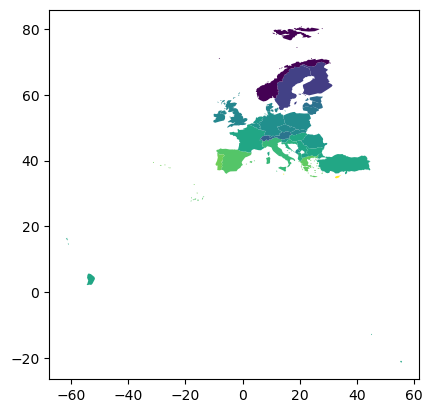

In [14]:
reduced_data_pd.plot("t2m_mean")

## Appendix

### Unadvised: return_as = 'pandas' for time-series

This results in very heavy memory usage but may be useful

In [15]:
reduced_data_pd = ek_climate.shapes.reduce(era5_data, nuts_data, return_as="pandas", mask_dim="FID")
reduced_data_pd[:5]

Returning reduced data in pandas format is considered experimental and may change in futureversions of earthkit-climate


id NUTS_ID  LEVL_CODE CNTR_CODE NAME_LATN NUTS_NAME  \
FID time                                                                       
DK  2015-01-01 00:00:00  DK      DK          0        DK   Danmark   Danmark   
    2015-01-01 06:00:00  DK      DK          0        DK   Danmark   Danmark   
    2015-01-01 12:00:00  DK      DK          0        DK   Danmark   Danmark   
    2015-01-01 18:00:00  DK      DK          0        DK   Danmark   Danmark   
    2015-01-02 00:00:00  DK      DK          0        DK   Danmark   Danmark   

                         MOUNT_TYPE  URBN_TYPE  COAST_TYPE FID  \
FID time                                                         
DK  2015-01-01 00:00:00           0          0           0  DK   
    2015-01-01 06:00:00           0          0           0  DK   
    2015-01-01 12:00:00           0          0           0  DK   
    2015-01-01 18:00:00           0          0           0  DK   
    2015-01-02 00:00:00           0          0           0  DK   

                                                                  geometry  \
FID time                                                                     
DK  2015-01-01 00:00:00  MULTIPOLYGON (((15.16290 55.09370, 15.09400 54...   
    2015-01-01 06:00:00  MULTIPOLYGON (((15.16290 55.09370, 15.09400 54...   
    2015-01-01 12:00:00  MULTIPOLYGON (((15.16290 55.09370, 15.09400 54...   
    2015-01-01 18:00:00  MULTIPOLYGON (((15.16290 55.09370, 15.09400 54...   
    2015-01-02 00:00:00  MULTIPOLYGON (((15.16290 55.09370, 15.09400 54...   

                         number   step  surface          valid_time  \
FID time                                                              
DK  2015-01-01 00:00:00       0 0 days      0.0 2015-01-01 00:00:00   
    2015-01-01 06:00:00       0 0 days      0.0 2015-01-01 06:00:00   
    2015-01-01 12:00:00       0 0 days      0.0 2015-01-01 12:00:00   
    2015-01-01 18:00:00       0 0 days      0.0 2015-01-01 18:00:00   
    2015-01-02 00:00:00       0 0 days      0.0 2015-01-02 00:00:00   

                           t2m_mean  
FID time                             
DK  2015-01-01 00:00:00  278.709229  
    2015-01-01 06:00:00  279.765015  
    2015-01-01 12:00:00  279.772217  
    2015-01-01 18:00:00  279.575684  
    2015-01-02 00:00:00  279.826721

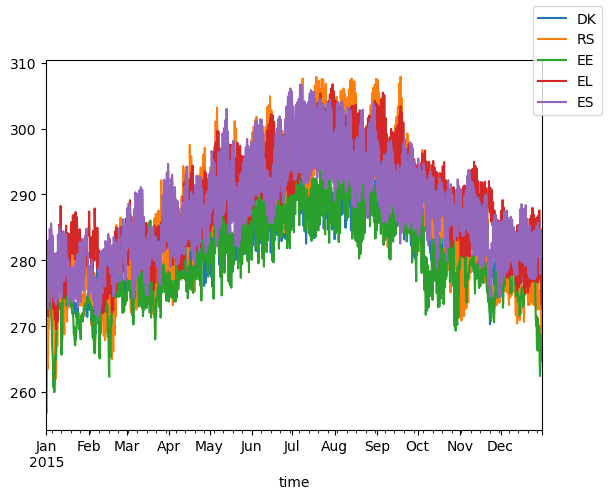

In [16]:
feature_index = "FID"
plot_var = "t2m_mean"
# plot_x_vals = reduced_data.attrs[f"{plot_var}_dims"]["time"]
fig, ax = plt.subplots(1)
for feature in reduced_data_pd.index.get_level_values(feature_index).unique()[:5]:
    temp = reduced_data_pd.xs(feature, level=feature_index)
    temp[plot_var].plot(ax=ax, label=feature)
fig.legend()